# Evaluation of the Helmholtz Solver
$$ (\nabla^2 + k^2)u = b$$

In [49]:
%matplotlib ipympl

In [50]:
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import scipy as sp

In [51]:
import sys
sys.path.append('../../modules')
from helmholtz_equation import sources, pml_conditions

In [52]:
from matplotlib.colors import LinearSegmentedColormap
cmap_source = LinearSegmentedColormap.from_list('source', ['green', 'white', 'purple'])

## 1. Finite Differences

In [53]:
u_i_j, u_i1_j, u_1i_j, u_i_j1, u_i_1j = sym.symbols('u_{i\,j} u_{i+1\,j} u_{i-1\,j} u_{i\,j+1} u_{i\,j-1}')
A_i_j, A_i1_j, A_1i_j = sym.symbols('A_{i\,j} A_{i+1\,j} A_{i-1\,j}')
B_i_j, B_i_j1, B_i_1j = sym.symbols('B_{i\,j} B_{i\,j+1} B_{i\,j-1}')
C_i_j = sym.symbols('C_{i\,j}')
dx, dy = sym.symbols('Delta_x Delta_y')

In [54]:
expr = (  1/(2*dx) * (A_i1_j - A_1i_j) * 1/(2*dx) * (u_i1_j - u_1i_j)
        + A_i_j/(dx**2) * (u_i1_j - 2*u_i_j + u_1i_j)
        + 1/(2*dy) * (B_i_j1 - B_i_1j) * 1/(2*dy) * (u_i_j1 - u_i_1j)
        + B_i_j/(dy**2) * (u_i_j1 - 2*u_i_j + u_i_1j)
        + C_i_j * u_i_j)
expr

A_{i,j}*(u_{i+1,j} - 2*u_{i,j} + u_{i-1,j})/Delta_x**2 + B_{i,j}*(u_{i,j+1} + u_{i,j-1} - 2*u_{i,j})/Delta_y**2 + C_{i,j}*u_{i,j} + (B_{i,j+1} - B_{i,j-1})*(u_{i,j+1} - u_{i,j-1})/(4*Delta_y**2) + (A_{i+1,j} - A_{i-1,j})*(u_{i+1,j} - u_{i-1,j})/(4*Delta_x**2)

In [55]:
expr_terms_collected = sym.collect(sym.expand(expr), [u_i_j, u_i1_j, u_1i_j, u_i_j1, u_i_1j])
expr_terms_collected

u_{i+1,j}*(A_{i+1,j}/(4*Delta_x**2) + A_{i,j}/Delta_x**2 - A_{i-1,j}/(4*Delta_x**2)) + u_{i,j+1}*(B_{i,j+1}/(4*Delta_y**2) - B_{i,j-1}/(4*Delta_y**2) + B_{i,j}/Delta_y**2) + u_{i,j-1}*(-B_{i,j+1}/(4*Delta_y**2) + B_{i,j-1}/(4*Delta_y**2) + B_{i,j}/Delta_y**2) + u_{i,j}*(-2*A_{i,j}/Delta_x**2 - 2*B_{i,j}/Delta_y**2 + C_{i,j}) + u_{i-1,j}*(-A_{i+1,j}/(4*Delta_x**2) + A_{i,j}/Delta_x**2 + A_{i-1,j}/(4*Delta_x**2))

## 2. Domain

In [56]:
main_domain_shape = (201, 201)
main_domain_extension = (-0.5, 0.5, -0.5, 0.5)
nbl = main_domain_shape[0]//2

nx = main_domain_shape[0] + nbl*2
ny = main_domain_shape[1] + nbl*2

lpml = (main_domain_extension[1] - main_domain_extension[0])/(main_domain_shape[0]-1) * nbl

domain_shape = (nx, ny)
domain_extension = tuple(x - lpml if i % 2 == 0 else x + lpml for i, x in enumerate(main_domain_extension))

x_array = np.linspace(domain_extension[0], domain_extension[1], nx)
y_array = np.linspace(domain_extension[2], domain_extension[3], ny)

dx = x_array[1] - x_array[0]
dy = y_array[1] - y_array[0]

nk = nx * ny
points_number = np.arange(nk)

## 3. Parameters

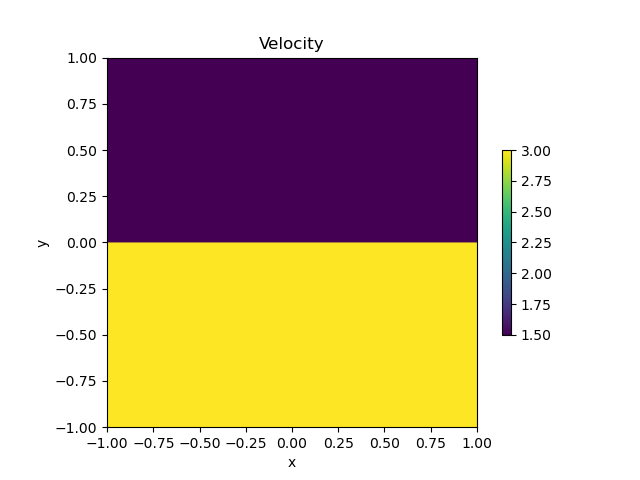

In [57]:
#frequency_array = np.linspace(1, 20, 5)
frequency_array = np.array([10])
#frequency_array = np.array([5, 10, 15, 20, 25])

nfrequencies = np.size(frequency_array)

alpha = 1.4

velocity = 1.5
velocity_array = np.ones((nx, ny))*velocity
velocity_array[:, :(ny-1)//2] = velocity*2

plt.figure()
plt.imshow(velocity_array.T, extent=domain_extension, origin='lower', cmap='viridis')
plt.colorbar(shrink=0.5)
plt.title('Velocity')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## 4. Source

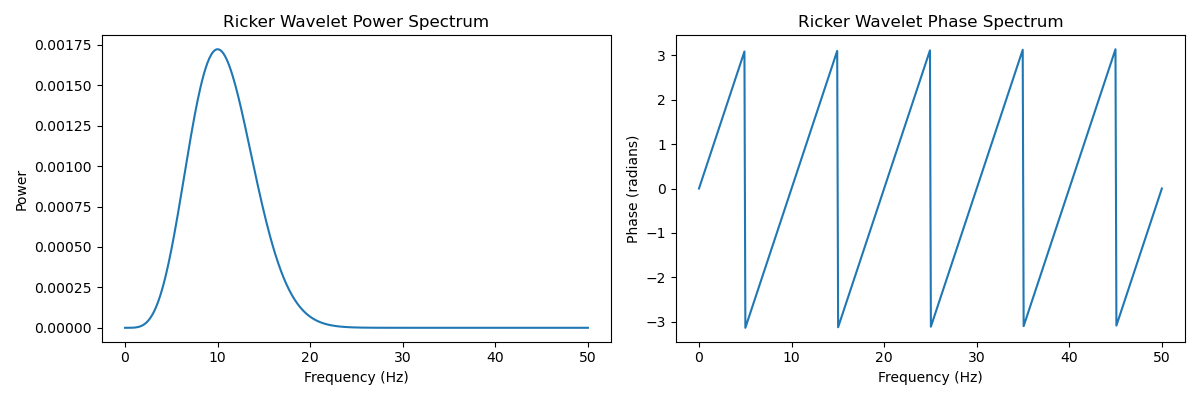

In [58]:
#source = sources.GaussianSource(amplitude=1e2, x_pos=0, y_pos=0.4, sigma=0.01, phase=np.pi/8)
source = sources.RickerWaveletFD(f=10, f0=10, t0=0.1, amplitude=1e2, x_pos=0, y_pos=0.4, sigma=0.01)
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(12, 4))
source.plot((ax, ax2), np.linspace(0, 50, 500))
fig.tight_layout()
plt.show()

## 5. Solver

In [59]:
u_arrays = np.zeros((nx, ny, nfrequencies), dtype=complex)
b_arrays = np.zeros((nx, ny, nfrequencies), dtype=complex)

In [60]:
for i, this_frequency in enumerate(frequency_array):
    source = sources.RickerWaveletFD(f=this_frequency, f0=10, t0=0.1, amplitude=1e2, x_pos=0, y_pos=0.4, sigma=0.01)
    u_arrays[..., i], b_arrays[..., i] = pml_conditions.helmholtz_pml_solution(nx, ny, x_array, y_array, dx, dy, points_number, nk, this_frequency,
                                                nbl, velocity_array, lpml, source, alpha)

Se soluciona el campo en cartesianas


## 6. Plotting

In [61]:
this_nfrequency = 0
u = u_arrays[..., this_nfrequency]
b = b_arrays[..., this_nfrequency]

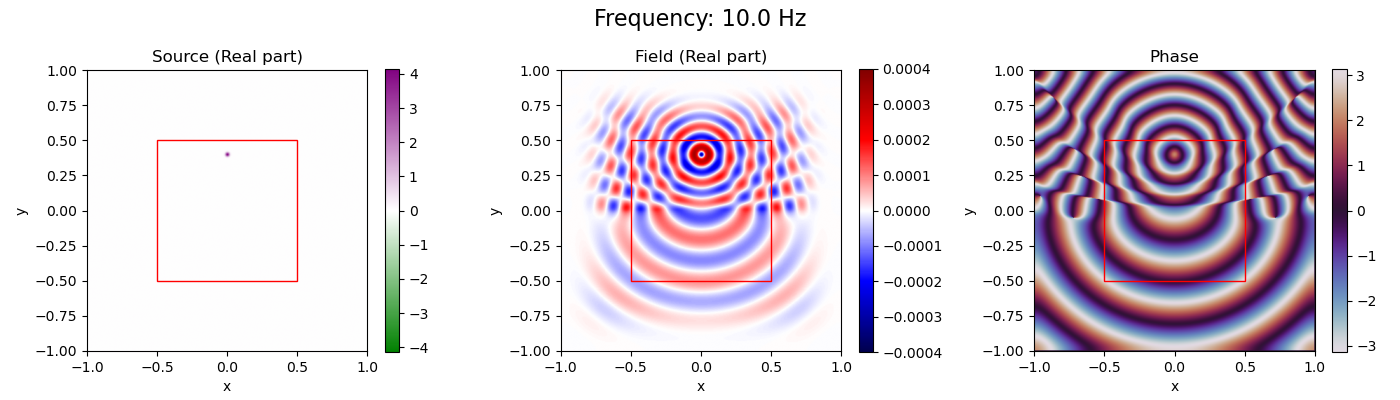

In [62]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(14, 4))
fig.suptitle(f'Frequency: {frequency_array[this_nfrequency]:.1f} Hz', fontsize=16)

rect_params = dict(
    xy=(main_domain_extension[0], main_domain_extension[2]), 
    width=main_domain_extension[1]-main_domain_extension[0], 
    height=main_domain_extension[3]-main_domain_extension[2], 
    linewidth=1, edgecolor='r', facecolor='none')

vmax = np.max(np.abs(b))
im0 = ax0.imshow(np.real(b).T, extent=domain_extension, origin='lower', cmap=cmap_source, vmin=-vmax, vmax=vmax)
fig.colorbar(im0, ax=ax0, shrink=0.9)
ax0.add_patch(patches.Rectangle(**rect_params))
ax0.set_title('Source (Real part)')
ax0.set_xlabel('x')
ax0.set_ylabel('y')

#vmax = np.max(np.abs(np.real(u)))
vmax = 4e-4
im1 = ax1.imshow(np.real(u).T, extent=domain_extension, origin='lower', cmap='seismic', vmin=-vmax, vmax=vmax)
fig.colorbar(im1, ax=ax1, shrink=0.9)
ax1.add_patch(patches.Rectangle(**rect_params))
ax1.set_title('Field (Real part)')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

im2 = ax2.imshow(np.angle(u).T, extent=domain_extension, origin='lower', cmap='twilight', vmin=-np.pi, vmax=np.pi)
fig.colorbar(im2, ax=ax2, shrink=0.9)
ax2.add_patch(patches.Rectangle(**rect_params))
ax2.set_title('Phase')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

fig.tight_layout()

plt.show()

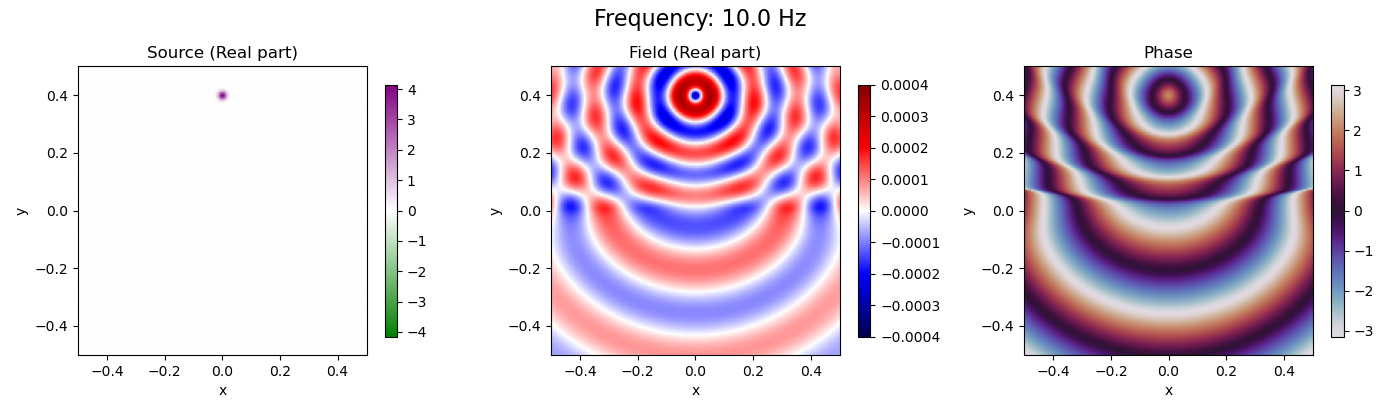

In [63]:
idx_main_domain = (slice(nbl, -nbl), slice(nbl, -nbl))

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(14, 4))
fig.suptitle(f'Frequency: {frequency_array[this_nfrequency]:.1f} Hz', fontsize=16)

vmax = np.max(np.abs(b))
im0 = ax0.imshow(np.real(b)[idx_main_domain].T, extent=main_domain_extension, origin='lower', cmap=cmap_source, vmin=-vmax, vmax=vmax)
fig.colorbar(im0, ax=ax0, shrink=0.8)
ax0.set_title('Source (Real part)')
ax0.set_xlabel('x')
ax0.set_ylabel('y')

# vmax = np.max(np.abs(np.real(u)))
vmax = 4e-4
im1 = ax1.imshow(np.real(u)[idx_main_domain].T, extent=main_domain_extension, origin='lower', cmap='seismic', vmin=-vmax, vmax=vmax)
fig.colorbar(im1, ax=ax1, shrink=0.8)
ax1.set_title('Field (Real part)')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

im2 = ax2.imshow(np.angle(u)[idx_main_domain].T, extent=main_domain_extension, origin='lower', cmap='twilight', vmin=-np.pi, vmax=np.pi)
fig.colorbar(im2, ax=ax2, shrink=0.8)
ax2.set_title('Phase')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

fig.tight_layout()

plt.show()

## 7. Source analysis

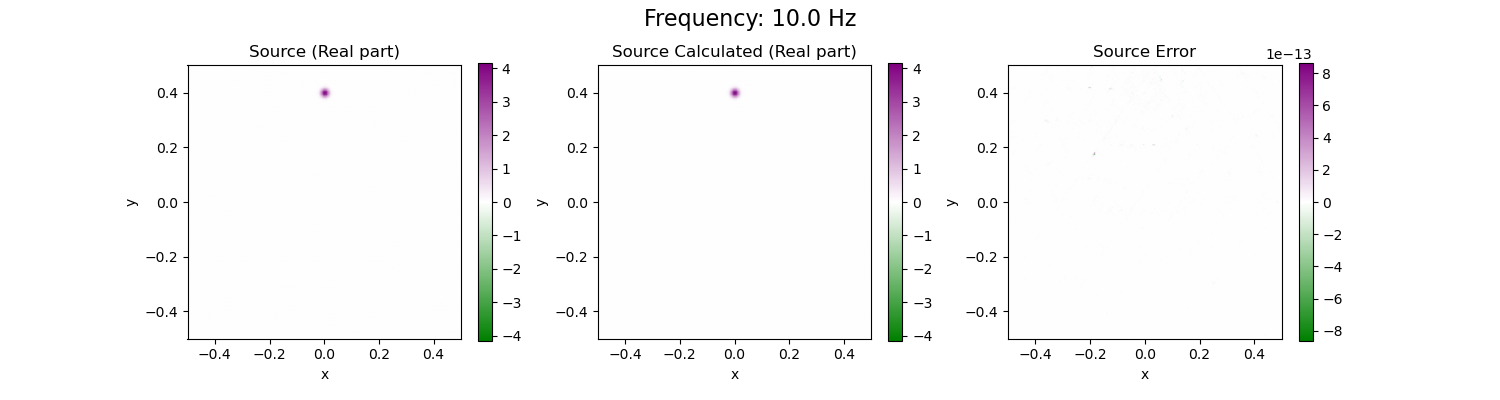

In [64]:
laplace = sp.ndimage.laplace(u, mode='mirror')/dx**2
second_term = (2*np.pi*frequency_array[this_nfrequency]/velocity_array)**2 * u
source_term_calculated = laplace + second_term

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle(f'Frequency: {frequency_array[this_nfrequency]:.1f} Hz', fontsize=16)

vmax = np.max(np.abs(b))
im0 = ax0.imshow(np.real(b)[idx_main_domain].T, extent=main_domain_extension, origin='lower', cmap=cmap_source, vmin=-vmax, vmax=vmax)
fig.colorbar(im0, ax=ax0, shrink=0.9)
ax0.set_title('Source (Real part)')
ax0.set_xlabel('x')
ax0.set_ylabel('y')

vmax = np.max(np.abs(source_term_calculated))
im1 = ax1.imshow(np.real(source_term_calculated)[idx_main_domain].T, extent=main_domain_extension, origin='lower', cmap=cmap_source, vmin=-vmax, vmax=vmax)
fig.colorbar(im1, ax=ax1, shrink=0.9)
ax1.set_title('Source Calculated (Real part)')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

error = (b - source_term_calculated)
vmax = np.max(np.abs(error[idx_main_domain]))
im2 = ax2.imshow(np.real(error)[idx_main_domain].T, extent=main_domain_extension, cmap=cmap_source, origin='lower', vmin=-vmax, vmax=vmax)
fig.colorbar(im2, ax=ax2, shrink=0.9)
ax2.set_title('Source Error')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

plt.show()